In [1]:
from bs4 import BeautifulSoup
import re
import os
from tqdm import tqdm
from collections import Counter
import torch
import time
import gensim
import pymorphy2
import numpy as np

In [2]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dev

device(type='cuda')

In [3]:
proj_types, proj_names, proj_descrs = [],[],[]
folders = os.listdir('texts')
for folder in tqdm(folders):
    f = open(f"texts/{folder}/choose", "r", encoding="utf-8")
    contents = f.read()
    soup = BeautifulSoup(contents, 'lxml')
    founded = soup.find_all('div', {'class': 'lr-project-value'})
    proj_types.append( re.sub(r'[\n\t]', '', founded[1].get_text().lower()) )
    proj_names.append( re.sub(r'[\n\t]', '', founded[3].get_text().lower()) )
    proj_descrs.append( re.sub(r'[\n\t]', '', founded[4].get_text().lower()) )
    f.close()
    


100%|██████████| 6605/6605 [00:36<00:00, 180.02it/s]


In [4]:
from collections import defaultdict

In [5]:
types_dict = defaultdict(int)
for proj_type in (proj_types):
    types_dict[proj_type] += 1
    
for key, value in sorted(types_dict.items(), key=lambda item: item[1], reverse = True):
    print("%s: %s" % (key, value))

другое: 2206
просвещение и образование — новые форматы и темы: 1851
зож: профилактика, а не лечение: 570
семья: сохранение традиций и ценностей: 533
искусственный интеллект и современные технологии на службе обществу: 523
75-я годовщина со дня победы в великой отечественной войне: 308
правовая защита граждан и предпринимателей: 216
проекты в области науки: 159
внутренний туризм: новые формы, новые маршруты: 157
культурно-историческое наследие россии: 82


In [6]:
topic = 'просвещение и образование — новые форматы и темы'

In [7]:
names, descrs = [], []
for i in range( len(proj_names) ):
    if proj_types[i] == topic:
        names.append( proj_names[i] )
        descrs.append( proj_descrs[i] )

In [8]:
len(names)

1851

In [9]:
# process text
for i in range( len(names) ):
    # lowcase, no , - : ; ( ) " ' « » and .
    #line = names[i].lower()
    line = names[i]
    line = re.sub(r'[\,\-\:\;\(\)\"\«\»\.\!\\\/]', ' ', line)
    line = re.sub(r"\'", ' ', line)
    # change all ... to space
    line = re.sub(r'\.+', ' ', line)
    # no doublespace
    line = re.sub(r' +', ' ', line)
    # no space after .
    #line = re.sub(r'\. ', '.', line)
    names[i] = line.strip()
    
    # lowcase, no , - : ; ( ) " ' « » keep .
    #line = descrs[i].lower()
    line = descrs[i]
    line = re.sub(r'[\,\-\:\;\(\)\"\«\»\\\/]', ' ', line)
    line = re.sub(r"\'", ' ', line)
    # change all ... to .
    line = re.sub(r'\.+', '.', line)
    # ! > .
    line = re.sub(r'\!', ".", line)
    # no doublespace
    line = re.sub(r' +', ' ', line)
    # no space after .
    line = re.sub(r'\. ', '.', line)
    # change all ... to .
    line = re.sub(r'\.+', '.', line)
    descrs[i] = line.strip()
    


In [10]:
names[0]

'проект нацелен на популяризацию образования в научной сфере заключается в проведении ряда семинаров для школьников открывающих путь к успеху в науке'

In [11]:
descrs[0]

'на сегодняшний день существует социальная проблема связанная с отсутствием информированности школьников о возможностях различных профессий в том числе профессий в области науки.зачастую школьники выбирают дальнейший путь развития с помощью родительского примера информации из сми и других источников о популярности и денежности той или иной сферы.при этом даже будучи студентами вузов не представляют о деятельности по будущей профессии.это значительно влияет на их мотивацию не только во время учебы но и сказывается на эффективности последующей работы.идея проекта заключается в том чтобы перенести школьников на этап работы учёным показать им образ их будущего в данной профессии что позволит выявить вдохновить и направить тех кто будет наиболее эффективным при обучении и работе в этой сфере.на практике будет организован ряд интерактивных семинаров на базе научно исследовательской лаборатории мгту им.н.э.баумана отражающий жизнь и работу в сфере науки погружающий и заинтересовывающий школьн

### Пробуем просто все предложения данной тематике собрать в кучу

In [12]:
all_sents = []
max_slen = 0
for i in range(len(descrs)):
    sents = descrs[i].split('.')
    for j in range(len(sents)):
        sents[j] = sents[j].strip()
        slen = len(sents[j])
        if slen > 0:
            all_sents.append(sents[j])

In [13]:
len(all_sents)

31148

In [14]:
all_sents[1]

'зачастую школьники выбирают дальнейший путь развития с помощью родительского примера информации из сми и других источников о популярности и денежности той или иной сферы'

In [15]:
text = ' '.join(all_sents)
text = re.sub(r'  ', ' ', text)  # убрать двойные пробелы
ALL_WORDS = set(text.strip().split(' '))
len(ALL_WORDS)

44944

In [16]:
c = Counter(text.split(' '))
c.most_common(10)

[('и', 21757),
 ('в', 18684),
 ('на', 7540),
 ('с', 6533),
 ('для', 5371),
 ('по', 4117),
 ('не', 3524),
 ('проекта', 3413),
 ('к', 3142),
 ('как', 2422)]

In [17]:
# # удаляем слова с числом повторений меньше 10
# todelete = set()
# for i, n in c.items():
#     if n < 10:
#         todelete.add(i)
        
# for i in todelete:
#     del c[i]

In [18]:
len(c.keys())

44944

In [19]:
model_w2v = gensim.models.KeyedVectors.load_word2vec_format('embed_models/183 - ruwikiruscorpora-func_upos_skipgram_300_5_2019/model.bin', binary=True)
model_w2v_weights = torch.FloatTensor(model_w2v.vectors).to(dev)

In [20]:
#weights = torch.FloatTensor(model.vectors) # formerly syn0, which is soon deprecated
EMBED_SIZE = model_w2v.vector_size
EMBED_SIZE

300

In [21]:
WORDS_COUNT = len(c.keys())
ALL_WORDS = set([w for w, _ in c.most_common(WORDS_COUNT)])
INDEX_TO_WORD = ['<pad>', '<miss>'] + list(ALL_WORDS)
len(INDEX_TO_WORD)

44946

In [22]:
WORD_TO_INDEX = {w: i for i, w in enumerate(INDEX_TO_WORD)}
INDEX_TO_WORD[:10]

['<pad>',
 '<miss>',
 'благотворительности',
 '\uf02dскоординированность',
 'перерывов',
 'коллективные',
 'поддержать',
 'ощущали',
 'индивидууму',
 'индия']

In [23]:
# create word_index to embedding array
index_to_embedding = torch.zeros([len(INDEX_TO_WORD), EMBED_SIZE], dtype=torch.float32)
cotags = {'ADJF':'ADJ', # pymorphy2: word2vec 
'ADJS' : 'ADJ', 
'ADVB' : 'ADV', 
'COMP' : 'ADV', 
'GRND' : 'VERB', 
'INFN' : 'VERB', 
'NOUN' : 'NOUN', 
'PRED' : 'ADV', 
'PRTF' : 'ADJ', 
'PRTS' : 'VERB', 
'VERB' : 'VERB',
# my
'CONJ' : 'ADV',
'INTJ' : 'NOUN',
'PREP' : 'PROPN',
'NUMR' : 'NUM',
'PRCL' : 'PROPN',
'NPRO' : 'PRON'
         }

In [24]:
morph = pymorphy2.MorphAnalyzer()
PAD_WORD = 'сингулярность'
MISS_WORD = 'хрень'
#index_to_embedding[0] = torch.from_numpy( model_w2v[PAD_WORD+"_NOUN"] )
index_to_embedding[0] = torch.zeros(EMBED_SIZE)
index_to_embedding[1] = torch.from_numpy( model_w2v[MISS_WORD+"_NOUN"] )

cnotfound_in_pymorphy = 0
cnotfound_in_w2v = 0

for i in tqdm( range(2,len(INDEX_TO_WORD)) ):
    word = INDEX_TO_WORD[i]
    #print (word)
    info = morph.parse(word)[0]
    if ('UNKN' in info.tag) or ('LATN' in info.tag) or ('NUMB' in info.tag) or ('PNCT' in info.tag) or ('ROMN' in info.tag):
        info = morph.parse(MISS_WORD)[0]
        cnotfound_in_pymorphy += 1
    w2v_form = info.normal_form + "_" + cotags[info.tag.POS]
    if w2v_form in model_w2v:
        index_to_embedding[i] = torch.from_numpy( model_w2v[w2v_form] )
    else:
        cnotfound_in_w2v += 1
        index_to_embedding[i] = torch.zeros(model_w2v.vector_size)

print (f'Not found pmorphy2: {cnotfound_in_pymorphy}, not found in w2v: {cnotfound_in_w2v}')

100%|██████████| 44944/44944 [00:07<00:00, 5711.49it/s]

Not found pmorphy2: 2700, not found in w2v: 6173


In [25]:
morph.parse('красивый')

[Parse(word='красивый', tag=OpencorporaTag('ADJF,Qual masc,sing,nomn'), normal_form='красивый', score=0.5, methods_stack=((<DictionaryAnalyzer>, 'красивый', 1800, 0),)),
 Parse(word='красивый', tag=OpencorporaTag('ADJF,Qual inan,masc,sing,accs'), normal_form='красивый', score=0.5, methods_stack=((<DictionaryAnalyzer>, 'красивый', 1800, 4),))]

In [26]:
beau = morph.parse('красивая')[0]
beau

Parse(word='красивая', tag=OpencorporaTag('ADJF,Qual femn,sing,nomn'), normal_form='красивый', score=1.0, methods_stack=((<DictionaryAnalyzer>, 'красивая', 1800, 7),))

In [27]:
beau.inflect({'femn'})

Parse(word='красивая', tag=OpencorporaTag('ADJF,Qual femn,sing,nomn'), normal_form='красивый', score=1.0, methods_stack=((<DictionaryAnalyzer>, 'красивая', 1800, 7),))

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

(array([7.703e+03, 6.894e+03, 6.249e+03, 4.393e+03, 2.440e+03, 1.389e+03,
        8.020e+02, 4.390e+02, 2.600e+02, 1.740e+02, 1.090e+02, 6.600e+01,
        5.200e+01, 3.800e+01, 2.600e+01, 2.400e+01, 1.500e+01, 6.000e+00,
        5.000e+00, 1.700e+01, 9.000e+00, 6.000e+00, 6.000e+00, 2.000e+00,
        4.000e+00, 3.000e+00, 5.000e+00, 1.000e+00, 2.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([  1.  ,   6.98,  12.96,  18.94,  24.92,  30.9 ,  36.88,  42.86,
         48.84,  54.82,  60.8 ,  66.78,  72.76,  78.74,  84.72,  90.7 ,
         96.68, 102.66, 108.64, 114.62, 120.6 , 126.58, 132.56, 138.54,
        144.52, 150.5 , 156.48, 162.46, 168.44, 174.42, 180.4 , 186.38,
        192.36, 198.34, 204.32, 210.3 , 216.28, 222.26, 228.24, 234.22,
        240.2 , 

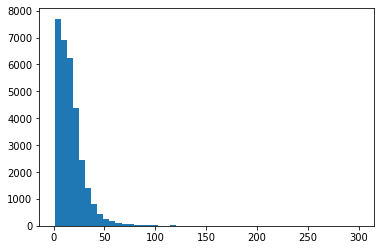

In [29]:
# распреление длины слов в предложении
plt.hist([len(s.split(' ')) for s in all_sents], bins=50)

In [30]:
MAX_LEN = 30

In [31]:
X = torch.zeros((len(all_sents), MAX_LEN), dtype=int)
# готовим матрицу - строка - предложение, столбец - индекс слова в этой позиции
for i in tqdm(range(len(all_sents))):
    for j, w in enumerate(all_sents[i].split(' ')):
        if j >= MAX_LEN:
            break
        X[i, j] = WORD_TO_INDEX.get(w, WORD_TO_INDEX['<miss>'])
        
X = X.to(dev)

100%|██████████| 31148/31148 [00:03<00:00, 10315.90it/s]


In [32]:
X[0:1]

tensor([[ 2314, 18653, 19083, 16791,  2163, 15945,  8645, 23788,  9949, 20937,
          6927, 26343, 23667, 14030, 16194, 15621,  3606, 44541, 16194, 15621,
         16461, 13935,     0,     0,     0,     0,     0,     0,     0,     0]],
       device='cuda:0')

In [33]:
X.shape

torch.Size([31148, 30])

In [34]:
a = [1,2,3]
[i*2 for i in a]

[2, 4, 6]

In [127]:
BATCH_SIZE = 30

In [65]:
class Network(torch.nn.Module):

    def __init__(self, dev, model_w2v_weights):
        super(Network, self).__init__()
        self.dev = dev
        self.word_embeddings = torch.nn.Embedding.from_pretrained(model_w2v_weights).to(self.dev)
        self.gru = torch.nn.GRU(EMBED_SIZE, 128, num_layers = 1, batch_first=True).to(self.dev)
        self.hidden2tag = torch.nn.Linear(128, len(INDEX_TO_WORD)).to(self.dev)
        
    def get_embeddings(self,sentences):
        csentences = sentences.size()[0]
        cwords = sentences.size()[1]
        embeds = torch.zeros(csentences, cwords, EMBED_SIZE).to(self.dev)
        for i in range(csentences):  
            for k in range(cwords):
                if sentences[i][k] == 0:
                    embeds[i][k] = self.word_embeddings[0]
                    break
                embeds[i][k] = torch.FloatTensor ([ emb for emb in self.word_embeddings[ sentences[i][k] ] ])
        return embeds

    def forward(self, sentences):
        embeds = self.word_embeddings(sentences)
        gru_out, state = self.gru(embeds)
        tag_space = self.hidden2tag(gru_out.reshape(-1, 128))
        return tag_space.reshape(sentences.shape[0], sentences.shape[1], -1), state
    
    def forward_state(self, sentences, state):
        #embeds = self.get_embeddings(sentences)
        embeds = self.word_embeddings(sentences)
        gru_out, state = self.gru(embeds, state)
        tag_space = self.hidden2tag(gru_out.reshape(-1, 128))
        return tag_space.reshape(sentences.shape[0], sentences.shape[1], -1), state

In [39]:
model = Network(dev, model_w2v_weights)
model.forward(X[0:1])[0].shape

torch.Size([1, 30, 44946])

In [90]:
def generate_sentence(line):
    sentence = line.split(' ')
    #sentence = ['к', 'а', 'к', ' ', 'р', 'а', 'н', 'о',' ']
    state = None
    for i in range(MAX_LEN):
        #X = torch.Tensor([[WORD_TO_INDEX[sentence[i]]]]).type(torch.long)
        X = torch.Tensor([[WORD_TO_INDEX.get(sentence[i],WORD_TO_INDEX['<miss>'])]]).type(torch.long)
        #get(w, WORD_TO_INDEX['<miss>']
        X = X.to(dev)
        if i == 0:
            result, state = model.forward(X)
        else:
            result, state = model.forward_state(X, state)
        prediction = result[0, -1, :]
        index_of_prediction = prediction.argmax()
        if i >= len(sentence) - 1:
            if index_of_prediction == 0:
                break
        sentence.append(INDEX_TO_WORD[index_of_prediction])
        
    line = ' '.join(sentence)
    line = re.sub(r'none.*$', '', line)
    print(line)

In [91]:
generate_sentence('проект направлена на')

проект направлена на направлен находится мой поделись с проект о ближним будь профессии с попасть с выбором форме психологами профессии кейс детей не брейн инвалидов только ринг оказывающих как квест благотворительную следствие с


In [128]:
lrate = 0.05

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lrate)
#optimizer = torch.optim.Adam(model.parameters(), lr=lrate)

In [129]:
count = 0

for ep in range(4000):
    
    start = time.time()
    train_loss = 0.
    train_passed = 0
    
    for i in range(int(len(X) / 100)):
        batch = X[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]
        X_batch = batch[:, :-1]
        Y_batch = batch[:, 1:].flatten()

        optimizer.zero_grad()
        answers, _ = model.forward(X_batch)
        answers = answers.view(-1, len(INDEX_TO_WORD))
        loss = criterion(answers, Y_batch)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        train_passed += 1
    end = time.time()
    
    count += 1
    if count == 1:
        count = 0
        trloss = train_loss / train_passed
        print("Epoch {}. Time: {:.3f}, Train loss: {:.3f}".format(ep, end - start, trloss))
        #generate_sentence('проект позволяет')

Epoch 0. Time: 3.592, Train loss: 1.654
Epoch 1. Time: 3.562, Train loss: 1.654
Epoch 2. Time: 3.566, Train loss: 1.652
Epoch 3. Time: 3.566, Train loss: 1.652
Epoch 4. Time: 3.565, Train loss: 1.651
Epoch 5. Time: 3.577, Train loss: 1.650
Epoch 6. Time: 3.579, Train loss: 1.650
Epoch 7. Time: 3.580, Train loss: 1.649
Epoch 8. Time: 3.578, Train loss: 1.649
Epoch 9. Time: 3.577, Train loss: 1.648
Epoch 10. Time: 3.579, Train loss: 1.647
Epoch 11. Time: 3.575, Train loss: 1.647
Epoch 12. Time: 3.570, Train loss: 1.647
Epoch 13. Time: 3.569, Train loss: 1.646
Epoch 14. Time: 3.569, Train loss: 1.646
Epoch 15. Time: 3.572, Train loss: 1.645
Epoch 16. Time: 3.572, Train loss: 1.645
Epoch 17. Time: 3.572, Train loss: 1.644
Epoch 18. Time: 3.574, Train loss: 1.644
Epoch 19. Time: 3.572, Train loss: 1.644
Epoch 20. Time: 3.573, Train loss: 1.643
Epoch 21. Time: 3.573, Train loss: 1.643
Epoch 22. Time: 3.572, Train loss: 1.643
Epoch 23. Time: 3.574, Train loss: 1.642
Epoch 24. Time: 3.572, Tra

KeyboardInterrupt: 

In [130]:
generate_sentence('предлагается')

предлагается создать площадку и запустить осознанный выбор места


In [131]:
generate_sentence('проект позволяет')

проект позволяет направлен школьникам на и территории т и <pad> реализовывать <pad> дома <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


In [132]:
generate_sentence('в нашей стране дети')

в нашей стране дети рамках стране сложилась в в в поколение журналах которых которых <pad> <pad> слушатели растут <pad> <pad> предоставить технического <pad> <pad> <pad> профиля <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


In [133]:
generate_sentence('низкий уровень образования')

низкий уровень образования уровень закрепления <pad> рейтинга за <pad> <pad> рубежом <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


In [134]:
generate_sentence('проект способен')

проект способен направлен на на популяризацию базе 2016 детских и домах обучить <pad> и <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


In [59]:
descrs[105]


'предлагается создание платформы и онлайн курсов ориентированных на людей среднего возраста для повышения языковой финансовой и юридической грамотности.формат курсов будет открытый то есть доступный для всех без каких либо ограничений в том числе и территориальных.технология курсов будет соответствовать требованиям технологии массовых открытых онлайн курсов моок .лекции будут прочитаны ведущими специалистами и преподавателями в соответствующих областях.после каждой лекции будут тесты для самопроверки по пройденному материалу.в конце обучения будет предложено творческое задание для взаимного оценивания.обучающиеся успешно прошедшие обучение будут допущены до аттестации по итогам которой будут выжданы электронные сертификаты подтверждающие результаты обучения.'

In [135]:
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, "model_allw_w2v_rnn1l-300-128-bs30loss1d5.pt")

In [47]:
# model = TheModelClass(*args, **kwargs)
# optimizer = TheOptimizerClass(*args, **kwargs)

checkpoint = torch.load("model_allw_w2v_rnn1l-300-128-loss0d86.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
loss = checkpoint['loss']

#model.eval()
model.train()

Network(
  (word_embeddings): Embedding(248118, 300)
  (gru): GRU(300, 128, batch_first=True)
  (hidden2tag): Linear(in_features=128, out_features=44946, bias=True)
)

In [45]:
model.train()

Network(
  (word_embeddings): Embedding(248118, 300)
  (gru): GRU(300, 128, batch_first=True)
  (hidden2tag): Linear(in_features=128, out_features=44946, bias=True)
)

In [141]:
# NO TRAIN TEST ONLY
BATCH_SIZE = 50
count = 0

for ep in range(1):
    
    start = time.time()
    train_loss = 0.
    train_passed = 0
    
    for i in range(int(len(X) / 100)):
        batch = X[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]
        X_batch = batch[:, :-1]
        Y_batch = batch[:, 1:].flatten()

        #optimizer.zero_grad()
        answers, _ = model.forward(X_batch)
        answers = answers.view(-1, len(INDEX_TO_WORD))
        loss = criterion(answers, Y_batch)
        train_loss += loss.item()

        #loss.backward()
        #optimizer.step()
        train_passed += 1
    end = time.time()
    
    count += 1
    if count == 1:
        count = 0
        trloss = train_loss / train_passed
        print("Epoch {}. Time: {:.3f}, Train loss: {:.3f}".format(ep, end - start, trloss))
        #generate_sentence('проект позволяет')

Epoch 0. Time: 2.087, Train loss: 1.747


In [164]:
c['преподаватели']

84

In [44]:
c['будет']

1283

In [48]:
c.most_common(500)

[('и', 21757),
 ('в', 18684),
 ('на', 7540),
 ('с', 6533),
 ('для', 5371),
 ('по', 4117),
 ('не', 3524),
 ('проекта', 3413),
 ('к', 3142),
 ('как', 2422),
 ('что', 2298),
 ('а', 2041),
 ('детей', 1997),
 ('из', 1893),
 ('о', 1651),
 ('проект', 1626),
 ('это', 1586),
 ('их', 1507),
 ('или', 1477),
 ('от', 1449),
 ('1', 1315),
 ('–', 1285),
 ('будет', 1283),
 ('у', 1203),
 ('образования', 1184),
 ('при', 1184),
 ('2', 1170),
 ('которые', 1116),
 ('за', 1075),
 ('также', 1052),
 ('3', 1010),
 ('развития', 987),
 ('но', 983),
 ('работы', 973),
 ('так', 973),
 ('обучения', 933),
 ('реализации', 926),
 ('жизни', 909),
 ('будут', 877),
 ('россии', 787),
 ('профессии', 767),
 ('может', 764),
 ('создание', 763),
 ('области', 763),
 ('людей', 759),
 ('деятельности', 758),
 ('быть', 735),
 ('только', 709),
 ('т', 708),
 ('то', 705),
 ('рамках', 705),
 ('до', 705),
 ('можно', 704),
 ('школьников', 701),
 ('более', 693),
 ('время', 686),
 ('проведение', 679),
 ('все', 676),
 ('4', 669),
 ('они', 66

In [162]:
# save descrs to disk
import pandas as pd
df = pd.DataFrame(descrs)
df.to_csv("descrs.csv", encoding = 'utf8')


### Пробуем эмбеддинги word2vec


ModuleNotFoundError: No module named 'gensim'